# Requesting Argo data from Ifremer erddap, standard mode

In standard mode, the Argo data fetcher library will perform post-processing to the data retrieved from the erddap. This post-processing is required to provide you with a currated collection of measurements directly usable for analysis, i.e. cleared from technical details of the Argo dataset.

List of post-processing:
- select appropriate fields for each variables (ie *adjusted* for D and A data modes).
- select measurements with good QC flags only (i.e. all variables with QC must 1 or 2).


***
Script prepared by [Guillaume Maze](http://github.com/gmaze) (Mar. 2020)

In [1]:
import sys, os
import numpy as np
import xarray as xr

try:
    import argopy
except ModuleNotFoundError:
    !pip install git+http://github.com/euroargodev/argopy.git
    import argopy
print("argopy:", argopy.__version__)
from argopy import DataFetcher as ArgoDataFetcher

# For plots:
import matplotlib.pyplot as plt
import matplotlib as mpl
import cmocean
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

argopy: 0.1


# Create an Argo data loader

Let's create a data loader instance that will cache data locally for later re-use:

In [2]:
# argo_loader = ArgoDataFetcher(cachedir='tmp') # If you to save fetched data to limit data transfer usage
argo_loader = ArgoDataFetcher()
argo_loader

<datafetcher 'Not initialised'>
Fetchers: 'profile', 'float' or 'region'
User mode: standard

It is said ``Not initialised`` because we didn't specify yet what kind of data selection we want to perform.

It also specifies a user mode set to ``standard`` by default. See other notebooks for the ``expert`` mode.

# Example of data fetching for a specific region

To request data for a specific space/time region, you can use the ``region()`` method that requires a region definition as a list of at least 6 values: ``[lon_min, lon_max, lat_min, lat_max, pres_min, pres_max]``
 
You can otherwise with 8 values to specify a time period: ``[lon_min, lon_max, lat_min, lat_max, pres_min, pres_max, date_min, date_max]``

## Zonal section, for a given year

In [3]:
box = [-80., 0., 26-0.5, 26+.5, 0, 1000, '2018-01-01','2018-12-31']
ds = argo_loader.region(box).to_xarray()
ds

<xarray.Dataset>
Dimensions:          (index: 77737)
Coordinates:
    latitude         (index) float64 26.08 26.08 26.08 ... 25.72 25.72 25.72
    longitude        (index) float64 -15.47 -15.47 -15.47 ... -63.1 -63.1 -63.1
  * index            (index) int64 0 1 2 3 4 5 ... 84907 84908 84909 84910 84911
    time             (index) datetime64[ns] 2018-01-01T20:16:00 ... 2018-12-30T15:47:00
Data variables:
    CYCLE_NUMBER     (index) float64 97.0 97.0 97.0 97.0 ... 236.0 236.0 236.0
    PLATFORM_NUMBER  (index) int64 6901620 6901620 6901620 ... 6901183 6901183
    PRES             (index) float64 6.0 7.0 8.0 9.0 ... 964.8 975.2 985.1 993.2
    PRES_ERROR       (index) float64 2.4 2.4 2.4 2.4 2.4 ... 5.0 5.0 5.0 5.0 5.0
    PSAL             (index) float64 36.81 36.81 36.81 ... 35.08 35.08 35.08
    PSAL_ERROR       (index) float64 0.01 0.01 0.01 0.01 ... 0.01 0.01 0.01 0.01
    TEMP             (index) float64 19.76 19.76 19.76 ... 6.986 6.888 6.792
    TEMP_ERROR       (index) float64 0.002 0.002 0.002 0.002 ... 0.01 0.01 0.01
Attributes:
    DATA_ID:               ARGO
    DOI:                   http://doi.org/10.17882/42182
    Downloaded_from:       http://www.ifremer.fr/erddap
    Downloaded_by:         gmaze
    Download_date:         2020/03/17
    Download_url:          http://www.ifremer.fr/erddap/tabledap/ArgoFloats.c...
    Download_constraints:  phy_[x=-80.00/0.00; y=25.50/26.50; z=0.0/1000.0; t...
    history:               Variables selected according to DATA_MODE; Variabl...

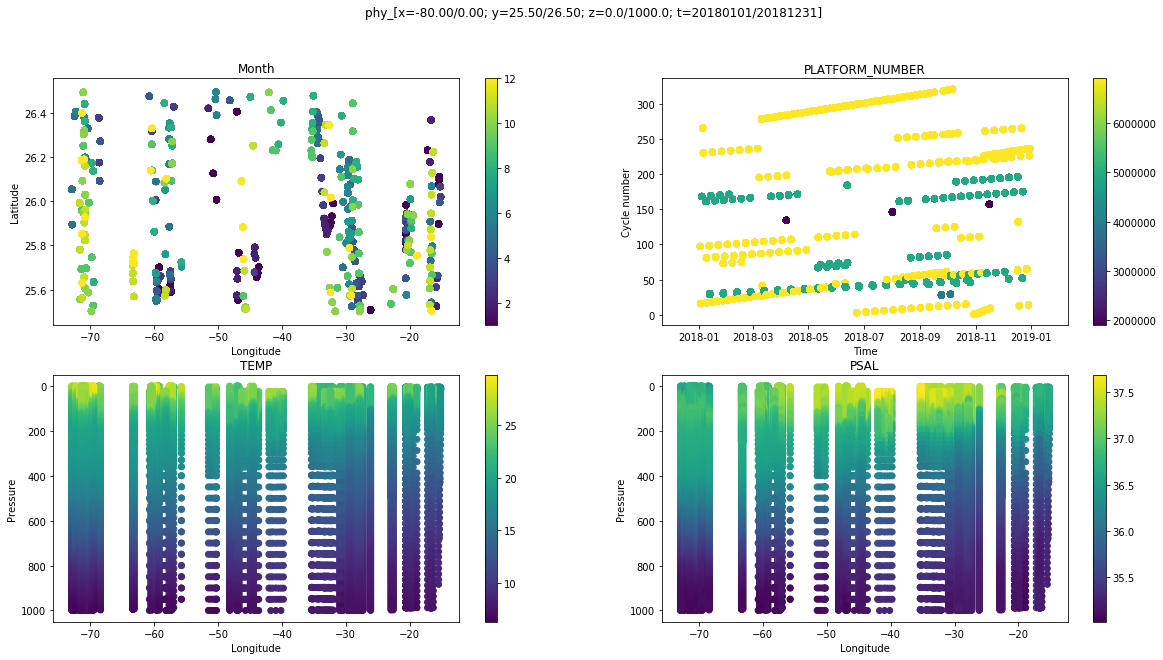

In [4]:
# Raw figure
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20,10))
ax = np.array(ax).flatten()

ix = 0
sc = ax[ix].scatter(ds['longitude'], ds['latitude'], c=ds['time.month'])
plt.colorbar(sc, ax=ax[ix])
ax[ix].set_xlabel('Longitude')
ax[ix].set_ylabel('Latitude')
ax[ix].set_title('Month')

ix += 1
sc = ax[ix].scatter(ds['time'].values, ds['CYCLE_NUMBER'], c=ds['PLATFORM_NUMBER'])
plt.colorbar(sc, ax=ax[ix])
ax[ix].set_xlabel('Time')
ax[ix].set_ylabel('Cycle number')
ax[ix].set_title('PLATFORM_NUMBER')

ix += 1
sc = ax[ix].scatter(ds['longitude'], ds['PRES'], c=ds['TEMP'])
plt.colorbar(sc, ax=ax[ix])
ax[ix].invert_yaxis()
ax[ix].set_xlabel('Longitude')
ax[ix].set_ylabel('Pressure')
ax[ix].set_title('TEMP')

ix += 1
sc = ax[ix].scatter(ds['longitude'], ds['PRES'], c=ds['PSAL'])
plt.colorbar(sc, ax=ax[ix])
ax[ix].invert_yaxis()
ax[ix].set_xlabel('Longitude')
ax[ix].set_ylabel('Pressure')
ax[ix].set_title('PSAL')

fig.suptitle(ds.attrs['Download_constraints']);

## Map of data around 200db depth for a single month

In [5]:
box = [-80., 0., 10., 65., 200-5., 200+5., '2018-01-01','2018-01-31']
ds = argo_loader.region(box).to_xarray()
ds

AttributeError: '_io.BytesIO' object has no attribute 'decode'

In [ ]:
plt.scatter(ds['longitude'], ds['latitude'], c=ds['PSAL'])
plt.colorbar(label=ds['PSAL'].attrs['units'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.gca().grid()
plt.title("%s\n%s" % (ds['PSAL'].attrs['long_name'], ds.attrs['Download_constraints']));

## Deployment over a region ?

In [ ]:
# Retrieve all data for a region near the surface and a single month:
box = [-80., -45, 10, 45, 0, 10, '2018-01-01','2018-12-31']
ds = argo_loader.region(box).to_xarray()

# Then select only the first cycle number:
this = ds.where(ds['CYCLE_NUMBER']==1, drop=True).drop_vars('CYCLE_NUMBER')

# And group by WMOs:
this = this.reset_coords().groupby('PLATFORM_NUMBER').min()
this

In [ ]:
# plt.scatter(this['longitude'], this['latitude'], c=this['time.dayofyear'])
# plt.colorbar(label='Day of the year')
plt.scatter(this['longitude'], this['latitude'], c=this['PLATFORM_NUMBER'])
plt.colorbar(label='PLATFORM_NUMBER')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.gca().grid()
plt.title("%s" % ds.attrs['Download_constraints']);

# Example of data fetching for a specific float

In [ ]:
ds = argo_loader.float(6902746).to_xarray()
ds

In [ ]:
# Get basic information about the float:
print('This float has performed: %i profiles' % len(np.unique(ds['CYCLE_NUMBER'])))
print('This float operated between %s and %s' % (ds['time'].min().values, ds['time'].max().values))
print('This float profiles range from %0.1fdb to %0.1fdb' % (ds['PRES'].min(), ds['PRES'].max() ))

In [ ]:
ds.argo.point2profile()

## Plot trajectory

In [ ]:
this = ds.reset_coords().groupby('CYCLE_NUMBER').min()
plt.plot(this['longitude'], this['latitude'], 'k-')
plt.scatter(this['longitude'], this['latitude'], c=this['CYCLE_NUMBER'])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.gca().grid()
plt.colorbar(label='CYCLE_NUMBER')
plt.title(ds.attrs['Download_constraints'])

## Water fall plots

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20,10), sharex=True, sharey=True)
ax = np.array(ax).flatten()

ix = 0
sc = ax[ix].scatter(ds['CYCLE_NUMBER'], ds['PRES'], c=ds['TEMP'], cmap=cmocean.cm.thermal)
plt.colorbar(sc, ax=ax[ix], label=ds['TEMP'].attrs['units'])
ax[ix].invert_yaxis()
ax[ix].set_ylabel("%s [%s]" % (ds['PRES'].attrs['long_name'], ds['PRES'].attrs['units']))
ax[ix].set_title(ds['TEMP'].attrs['long_name'])

ix += 1
sc = ax[ix].scatter(ds['CYCLE_NUMBER'], ds['PRES'], c=ds['PSAL'], cmap=cmocean.cm.haline)
plt.colorbar(sc, ax=ax[ix], label=ds['PSAL'].attrs['units'])
# ax[ix].invert_yaxis()
ax[ix].set_xlabel(ds['CYCLE_NUMBER'].attrs['long_name'])
ax[ix].set_ylabel("%s [%s]" % (ds['PRES'].attrs['long_name'], ds['PRES'].attrs['units']))
ax[ix].set_title(ds['PSAL'].attrs['long_name']);


## Super-imposed profiles

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10), sharey=True)
ax = np.array(ax).flatten()

ix = 0
sc = ax[ix].scatter(ds['TEMP'], ds['PRES'], c=ds['CYCLE_NUMBER'])
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_xlabel(ds['TEMP'].attrs['units'])
ax[ix].set_ylabel("%s [%s]" % (ds['PRES'].attrs['long_name'], ds['PRES'].attrs['units']))
ax[ix].set_title(ds['TEMP'].attrs['long_name'])

ix += 1
sc = ax[ix].scatter(ds['PSAL'], ds['PRES'], c=ds['CYCLE_NUMBER'])
plt.colorbar(sc, ax=ax[ix], label=ds['CYCLE_NUMBER'].attrs['long_name'])
ax[ix].grid()
ax[ix].set_xlabel(ds['PSAL'].attrs['units'])
ax[ix].set_title(ds['PSAL'].attrs['long_name']);


## T/S diagram

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,6))
ax = np.array(ax).flatten()
ix = 0
sc = ax[ix].scatter(ds['PSAL'], ds['TEMP'], c=ds['CYCLE_NUMBER'])
ax[ix].grid()
ax[ix].set_xlabel("%s [%s]" % (ds['PSAL'].attrs['long_name'], ds['PSAL'].attrs['units']))
ax[ix].set_ylabel("%s [%s]" % (ds['TEMP'].attrs['long_name'], ds['TEMP'].attrs['units']))
plt.title(ds.attrs['Download_constraints']);

# Example of data fetching for a specific profile

In [ ]:
ds = argo_loader.profile(6902746, 12).to_xarray()
ds

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,10), sharey=True)
ax = np.array(ax).flatten()

ix = 0
ax[ix].plot(ds['TEMP'], ds['PRES'], '.-')
ax[ix].grid()
ax[ix].invert_yaxis()
ax[ix].set_xlabel(ds['TEMP'].attrs['units'])
ax[ix].set_ylabel("%s [%s]" % (ds['PRES'].attrs['long_name'], ds['PRES'].attrs['units']))
ax[ix].set_title(ds['TEMP'].attrs['long_name'])

ix += 1
ax[ix].plot(ds['PSAL'], ds['PRES'], '.-')
ax[ix].grid()
ax[ix].set_xlabel(ds['PSAL'].attrs['units'])
ax[ix].set_title(ds['PSAL'].attrs['long_name']);

fig.suptitle(ds.attrs['Download_constraints']);

***
This work is part and was supported by the following projects:
<div>
<img src="https://avatars1.githubusercontent.com/u/58258213?s=460&v=4" width="70"/>
<img src="http://www.argo-france.fr/wp-content/uploads/2019/10/Argo-logo_banner-color.png" width="200"/>
<img src="https://www.umr-lops.fr/var/storage/images/_aliases/logo_main/medias-ifremer/medias-lops/logos/logo-lops-2/1459683-4-fre-FR/Logo-LOPS-2.png" width="70"/>
</div>